In [ ]:
num_parties = 1  ## number of participating parties
dataset = 'pneumoniamnist.npz'
handlerName = 'PneumoniaMedmnistDataHandler'
handler ='pneumoniaHandler.py'

# Definição do modelo

Na célula a seguir deve-se especificar as configurações do modelo para a base de dados que se deseja trabalhar. Ao executar tal célula, o modelo será gerado, compilado e salvo para uso futuro.

Com a ferramenta da **IBM** é possível gerar modelos para as principais ferramentas do mercado. Como por exemplo, **Keras**, **Pytorch**, **Sklearn** e **TensorFlow**.

**OBS:.** O exemplo a seguir consiste no modelo para treinamento do **Mnist** com **Keras**.

In [ ]:
import os

import keras
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten
from keras.models import Sequential
def save_model_config(folder_configs):
    num_classes = 10
    img_rows, img_cols = 28, 28
    if K.image_data_format() == 'channels_first':
        input_shape = (1, img_rows, img_cols)
    else:
        input_shape = (img_rows, img_cols, 1)

    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])

    if not os.path.exists(folder_configs):
        os.makedirs(folder_configs)

    # Save model
    fname = os.path.join(folder_configs, 'compiled_keras.h5')
    model.save(fname)
    print(fname)

    K.clear_session()
    # Generate model spec:
    spec = {
        'model_name': 'keras-cnn',
        'model_definition': fname
    }

    model = {
        'name': 'KerasFLModel',
        'path': 'ibmfl.model.keras_fl_model',
        'spec': spec
    }

    return model
save_model_config('examples/configs/keras_classifier')

# Definição do aggregator

O agregador carrega consigo as informações de conexão referentes a máquina de execução. Além disso, seu arquivo de configuração possui informações sobre o algoritmo de **fusão**, **hiper parâmetros do treinamento** e o **protocolo**.

* **Connection:** Possui informações como **IP** e **porta** da máquina agregadora além do tipo da conexão, que no exemplo a seguir foi utilizado **Flask**.

* **Data:** Possui informações sobre os dados a serem trabalhados, como por exemplo, o caminho do arquivo **.npz** da base de dados e o **Handler** específico para a leitura dessas informações.

* **Fusion:** Este campo especifica quais dos métodos de fusão será utilizado. Pox exemplo, **Iterative Average**, **FedAvg**, **Gradient Average**, entre outros.

* **Hiper parâmetros:** Existem dois tipos de Hiper parâmetros. Globais e locais, no global é definido o tempo máximo de conexão, a quantidade de participantes do treinamento, quorum mínimo de participantes para que um treinamento se inicie, quantidade de épocas globais e acurácia nínima para  que o treinamento seja interrompido. Já os hiper parâmetros locais definem a quantidade de épocas locais e o valor do otimizador.

In [ ]:
agg_config = {
    'connection': {
        'info': {
            'ip': '127.0.0.1',
            'port': 5000,
            'tls_config': {
                'enable': 'false'
            }
        },
        'name': 'FlaskConnection',
        'path': 'ibmfl.connection.flask_connection',
        'sync': 'False'
    },
    'data': {
        'info': {
            'npz_file': str(dataset)
        },
        'name': handlerName,
        'path': handler
    },
    'fusion': {
        'name': 'IterAvgFusionHandler',
        'path': 'ibmfl.aggregator.fusion.iter_avg_fusion_handler'
    },
    'hyperparams': {
        'global': {
            'max_timeout': 60,
            'num_parties': num_parties,
            'perc_quorum': 1,
            'rounds': 3,
            'termination_accuracy': 0.9
        },
        'local': {
            'optimizer': {
                'lr': 0.01
            },
            'training': {
                'epochs': 3
            }
        }
    },
    'protocol_handler': {
        'name': 'ProtoHandler',
        'path': 'ibmfl.aggregator.protohandler.proto_handler'
    }
}

# Iniciando o Aggregator

Para iniciar um novo agregador é preciso instânciar um **Aggregator** passando as configurações geradas acima. Existem alguns comandos pré-configurados na própria biblioteca para realização do treinamento:

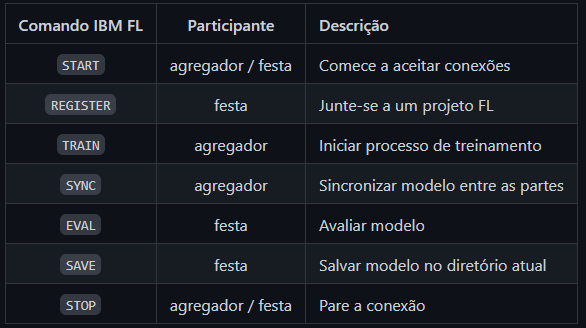

In [ ]:
from ibmfl.aggregator.aggregator import Aggregator
aggregator = Aggregator(config_dict=agg_config)

aggregator.start()

# Iniciando treinamento

Para a realização do treinamento devemos a princípio inicializar as métricas de quantidade de participantes, acurácia e iterações. Em seguida, definimos métricas para a coleta de informações e por fim, após a conexão dos participantes se estabelecerem, iniciamos o treinamento. 

In [ ]:
"""
#1 Initialize the metrics collector variables
"""
num_parties = agg_config['hyperparams']['global']['num_parties']
eval_party_accuracy = [[] for _ in range(num_parties)]
iterations = [[] for _ in range(num_parties)]

"""
#2 Register handler for metrics collector
"""
def get_metrics(metrics):
    keys = list(metrics['party'].keys())
    keys.sort()
    for i in range(len(keys)):
      eval_party_accuracy[i].append(metrics['party'][keys[i]]['acc'])
      iterations[i].append(metrics['fusion']['curr_round']*agg_config['hyperparams']['local']['training']['epochs'])
      
mh = aggregator.fusion.metrics_manager
mh.register(get_metrics)


"""
#3 start the training
"""
for x in range(2):
    aggregator.start_training()

# Finalizando o treinamento

Por fim, devemos parar nosso agregador utilizando o comando **STOP**.

In [ ]:
aggregator.stop()